# [TOTVS Labs - Data Challenge for Data Scientist position](https://totvslabs.recruiterbox.com/jobs/fk06t8s/)
**Fernando Martinelli Ramacciotti - fernandoramacciotti@gmail.com**


In this challenge we wil use a [dataset](https://github.com/TOTVS/MDMStatic/blob/master/code-challenge/TOTVS%20Labs%20-%20AI%20Challenge%20-%20Dataset.zip?raw=true) of transactions (notas fiscais eletrônicas) from a restaurant and we should complete the following tasks:
1. Parse and extract the data.
2. Identify a pattern on any set of fields that can help predict how much a customer will spend.
3. Calculate a sales forecast for the next week.

---
## 1. Parsing the data
Let us first import the necessary libraries and then proceed with our analysis.

In [1]:
# libraries importing block
import numpy as np                        # linear algebra
import pandas as pd                       # data processing
import matplotlib.pyplot as plt           # data visualization
%matplotlib inline
import seaborn as sns                     # data visualization
from pandas.io.json import json_normalize # JSON-like structures to be flatten
import json                               # JSON treatment
from scipy import stats                   # useful statistics handling functions
from collections import Counter           # Counter operations
import datetime                           # datetime handling 

from fbprophet import Prophet                        # Facebook's prophet forecasting package
from sklearn.metrics import mean_squared_error       # mean squared error for model evaluation 

plt.rcParams['figure.figsize'] = (12, 8)  # plot figure size

Our dataset has been download and stored at the subfolder *input*.

Since it looks like a JSON structured file, we will parse it as if it was a JSON file using pandas.

We can see that `dets` will be a nested column.

One way to normalize it would be to pass the `dets` column to *json_normalize*, one row at the time, and create an ID (`nf_id`) for each receipt, so that we can merge with the original `data` data frame.

Now we merge `df_items` and `data` into a single data frame and then we can work on our analysis.

In [2]:
# function that loads the data and already split into train and test sets
def parse_data(filename, test_size=0.2):
    raw = json.load(open(filename))
    data = json_normalize(data=raw, sep='_')
    data.index.name = 'nf_id'
    #data_train, data_test = train_test_split(data, test_size=test_size)
    
    return data

In [3]:
# function to flatten the dets column
def flat_dets(data):
    
    df_items = pd.DataFrame()
    for i in range(0, len(data)):
        index_nf = pd.DataFrame({'nf_id': data.index[i] * np.ones(len(data['dets'].values[i]))}) # id creation for each receipt with the size of the number of items
        df_aux = pd.concat([index_nf, json_normalize(data['dets'].values[i], sep='_')], axis=1)
        df_items = pd.concat([df_items, df_aux], axis=0, ignore_index=True)

    df_items.set_index('nf_id', inplace=True)
    data_merged = df_items.join(data, how='outer')
    
    data_merged.reset_index(inplace=True)   # reset the index

    # transform the column ide_dhEmi_$date in datetime format and set it as index
    data_merged.set_index(pd.to_datetime(data_merged['ide_dhEmi_$date'], format='%Y-%m-%d %H:%M:%S'), inplace=True) 
    
    # adding day of the week, day of month and hour columns
    data_merged['dayofweek'] = data_merged.index.weekday_name
    data_merged['date'] = data_merged.index.date
    data_merged['day'] = data_merged.index.day
    data_merged['hour'] = data_merged.index.hour
    
    return data_merged

In [4]:
data = parse_data(filename='./input/sample.txt')
data = flat_dets(data)

In [5]:
data.index

DatetimeIndex(['2016-01-05 12:01:54', '2016-01-05 12:01:54',
               '2016-01-05 12:03:52', '2016-01-05 12:03:52',
               '2016-01-05 12:16:40', '2016-01-05 12:16:40',
               '2016-01-05 12:17:50', '2016-01-05 12:18:35',
               '2016-01-05 12:20:00', '2016-01-05 12:20:00',
               ...
               '2016-01-23 14:48:17', '2016-01-23 14:48:17',
               '2016-01-23 14:56:16', '2016-01-23 14:56:16',
               '2016-01-23 14:56:24', '2016-01-23 14:56:24',
               '2016-01-23 14:56:24', '2016-01-23 14:56:24',
               '2016-01-23 14:56:35', '2016-01-23 14:56:35'],
              dtype='datetime64[ns]', name='ide_dhEmi_$date', length=3547, freq=None)

It seems that we have data from Jan 5, 2016 to Jan 23, 2016 and the resolution is on a second basis.

Since for time series we cannot simple randomly shuffle the dataset and split them into train and test (validation) sets, the usual method to validate the forecast model to be built is to specify a holdout period. In our case, since we have only 3 weeks of data and we need to forecast the next week's sales, let's pick only 2 days for validation (Jan 22nd and Jan 23rd).

In [6]:
train = data[data.index < '2016-01-22 00:00:00']
test = data[data.index >= '2016-01-22 00:00:00']

In [7]:
train.index

DatetimeIndex(['2016-01-05 12:01:54', '2016-01-05 12:01:54',
               '2016-01-05 12:03:52', '2016-01-05 12:03:52',
               '2016-01-05 12:16:40', '2016-01-05 12:16:40',
               '2016-01-05 12:17:50', '2016-01-05 12:18:35',
               '2016-01-05 12:20:00', '2016-01-05 12:20:00',
               ...
               '2016-01-21 22:58:42', '2016-01-21 22:59:29',
               '2016-01-21 22:59:29', '2016-01-21 22:59:29',
               '2016-01-21 22:59:29', '2016-01-21 23:01:49',
               '2016-01-21 23:01:49', '2016-01-21 23:01:49',
               '2016-01-21 23:11:07', '2016-01-21 23:11:07'],
              dtype='datetime64[ns]', name='ide_dhEmi_$date', length=3267, freq=None)

---
## 2. Analysis

#### Describing our train set

In [8]:
def describe_train(data):
    grouped = data.groupby(by='nf_id').sum()
    n_receipts = len(grouped)
    avg_spent_receipt = grouped['prod_vProd'].mean()
    prod_counter = Counter(data['prod_xProd'])
    n_products = len(prod_counter) 
    
    print('There are {:,} transactions'.format(n_receipts))
    print('The average spending is $ {:,.2f} per receipt'.format(avg_spent_receipt))
    print('There are {:,} different products'.format(n_products))
    
    return (n_receipts, avg_spent_receipt, n_products, prod_counter)

In [9]:
n_receipts, avg_spent_receipt, n_products, prod_counter = describe_train(train)

There are 1,504 transactions
The average spending is $ 55.64 per receipt
There are 24 different products


#### Distribution of spending

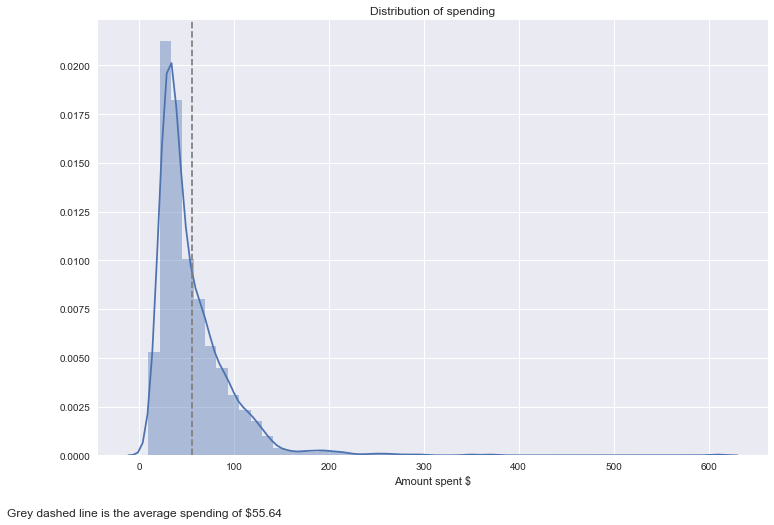

In [10]:
sns.distplot(train.groupby(by='nf_id').sum()['prod_vProd'])
plt.axvline(x=avg_spent_receipt, 
            linestyle='dashed', 
            color='grey')
plt.title('Distribution of spending')
plt.xlabel('Amount spent $')
plt.figtext(0.02, 0.02, 'Grey dashed line is the average spending of ${:,.2f}'.format(avg_spent_receipt))
plt.savefig('./plots/spending_distribution.png')

It is a right-skewed distribution with heavy right-tail. Visually, after $150, there only a very few data points and maybe they could be considered as outliers

#### Seasonality

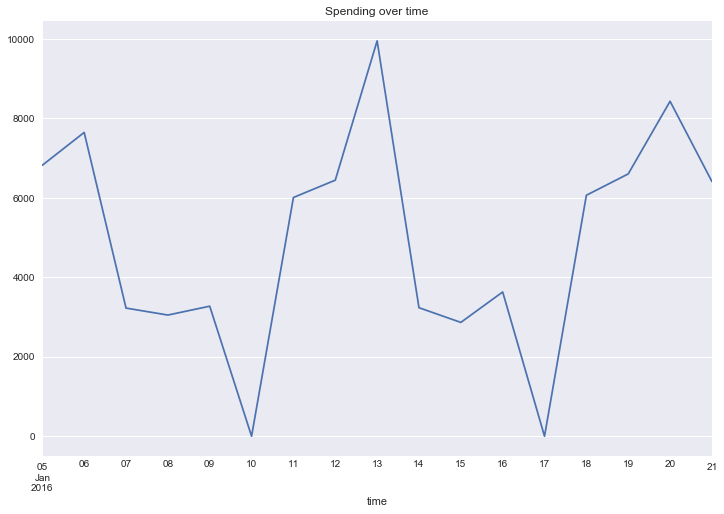

In [11]:
train.resample('D').sum()['prod_vProd'].fillna(0).plot()
plt.title('Spending over time')
plt.xlabel('time')
plt.savefig('./plots/spending_overtime.png')

Sundays have zero spending (days 10 and 17). We can see a seasonality that Tuesdays and Wednesdays of each week seem to have a higher spending than the other days and the end  of the week seems to have less spending. We can clearly see it on the barplot below:

In [12]:
# weekdays ordering
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'] # there is no Sunday data

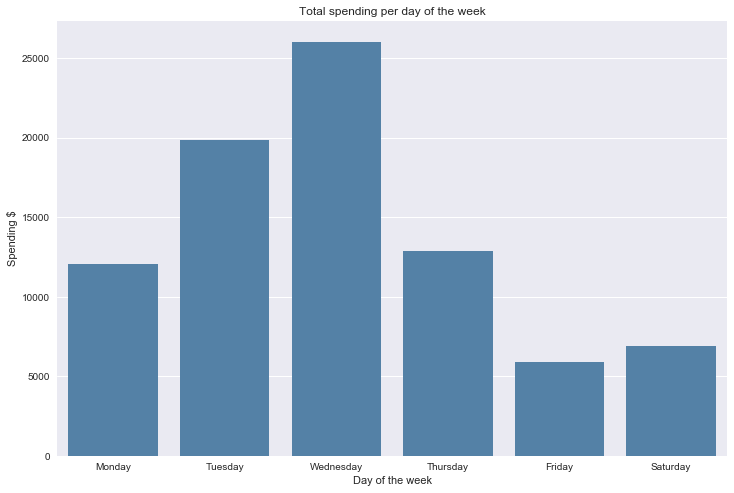

In [13]:
sns.barplot(x='dayofweek', y='prod_vProd', 
            data=train.groupby(by=['dayofweek']).sum().reset_index(), 
            order=weekday_order, 
            color='steelblue')
plt.title('Total spending per day of the week')
plt.ylabel('Spending $')
plt.xlabel('Day of the week')
plt.savefig('./plots/spending_total_per_dayofweek.png')

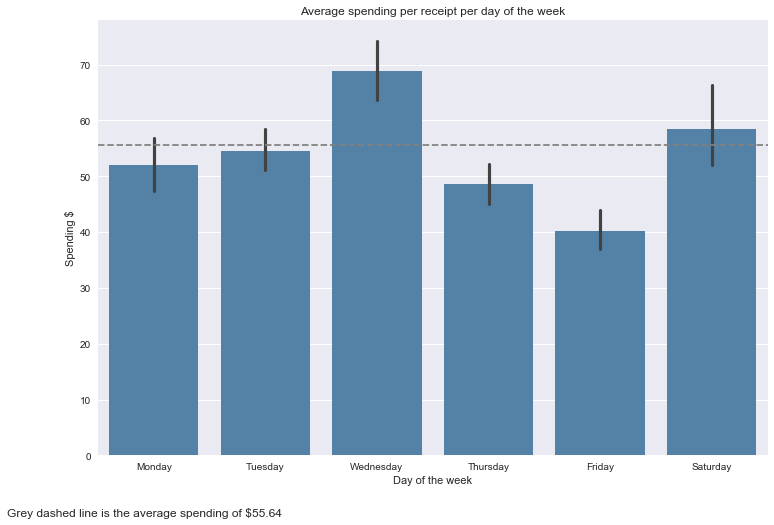

In [14]:
sns.barplot(x='dayofweek', y='prod_vProd', 
            data=train.groupby(by=['nf_id', 'dayofweek']).sum().reset_index(), 
            order=weekday_order, 
            color='steelblue')
plt.axhline(y=avg_spent_receipt,
            color='grey',
            linestyle='dashed')
plt.figtext(0.02, 0.02, 'Grey dashed line is the average spending of ${:,.2f}'.format(avg_spent_receipt))
plt.title('Average spending per receipt per day of the week')
plt.ylabel('Spending $')
plt.xlabel('Day of the week')
plt.savefig('./plots/spending_per_receipt_dayofweek.png')

It is interesting to note that on Wednesdays and Saturdays the average spending is above the unconditional average spending, being Wednesdays the maximum average spending and Fridays the minimum.
It is interesting that per-receipt spending on Saturday does not comply with our observations from the previous chart that the end of the week has less spending. Perhaps there are less volume than the beginning of the week, so that total spending on Saturday is still less than Wednesday, for example, even if its average spending per receipt is above the average.

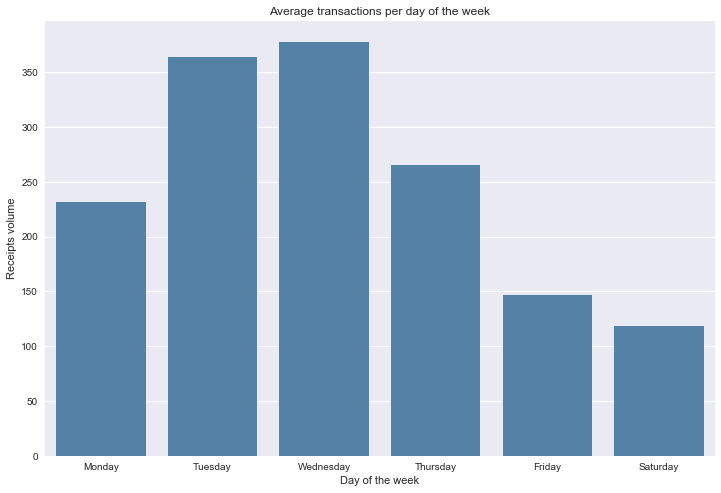

In [15]:
sns.countplot(x='dayofweek', 
              data=train.groupby(by=['nf_id', 'dayofweek']).count().reset_index(), 
              order=weekday_order, 
            color='steelblue')
plt.title('Average transactions per day of the week')
plt.ylabel('Receipts volume')
plt.xlabel('Day of the week')
plt.savefig('./plots/transactions_per_dayofweek.png')

And this volume chart confirms our previous hypothesis - there is less volume and the end of the week, specially Saturdays

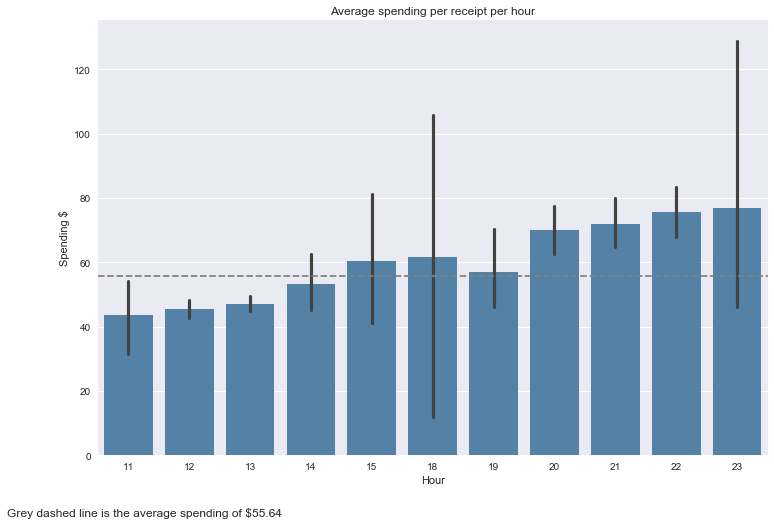

In [16]:
sns.barplot(x='hour', y='prod_vProd', 
            data=train.groupby(by=['nf_id', 'hour']).sum().reset_index(), 
            color='steelblue')
plt.axhline(y=avg_spent_receipt,
            color='grey',
            linestyle='dashed')
plt.figtext(0.02, 0.02, 'Grey dashed line is the average spending of ${:,.2f}'.format(avg_spent_receipt))
plt.title('Average spending per receipt per hour')
plt.ylabel('Spending $')
plt.xlabel('Hour')
plt.savefig('./plots/spending_per_receipt_hour.png')

It might be interesting group the hours in Lunch and Dinner groups, as follows:
* Lunch is up to 17h;
* Dinner otherwise.

In [17]:
def lunch_dinner_grouping(data):
    data['lunch_dinner'] = data['hour'].apply(lambda x: 'Lunch' if x <= 16 else 'Dinner')
    
    return data

In [18]:
train = lunch_dinner_grouping(train)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


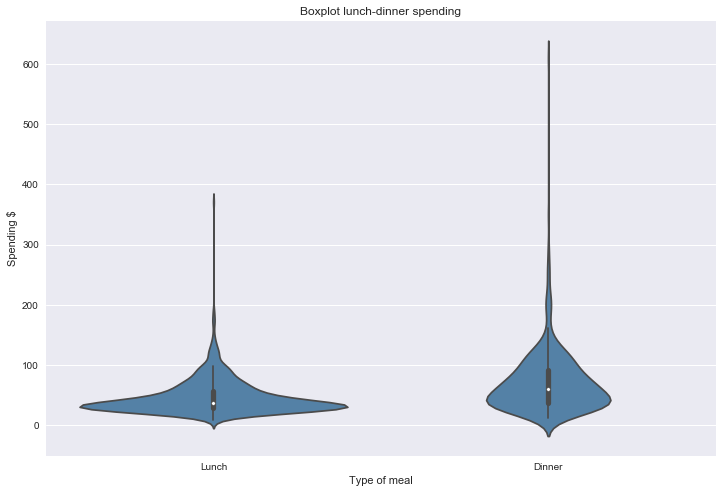

In [19]:
sns.violinplot(x='lunch_dinner', y='prod_vProd', 
            data=train.groupby(by=['nf_id', 'lunch_dinner']).sum().reset_index(), 
            color='steelblue')

plt.title('Boxplot lunch-dinner spending')
plt.ylabel('Spending $')
plt.xlabel('Type of meal')
plt.savefig('./plots/boxplot_lunch_dinner.png')

it seems that the average dinner spending is higher than lunch spending. In order to formally evaluate it, let's run a t-test of equal sample means.

In [20]:
train_aux = train.groupby(by=['nf_id', 'lunch_dinner']).sum().reset_index()
lunch_values = train_aux[train_aux['lunch_dinner'] == 'Lunch']['prod_vProd']
dinner_values = train_aux[train_aux['lunch_dinner'] == 'Dinner']['prod_vProd']

print('Lunch average spending: $ {:,.2f}'.format(lunch_values.mean()))
print('Dinner average spending: $ {:,.2f}'.format(dinner_values.mean()))
print('Two-sided T-Test rejects null as equal sample mean at {:f} significance'.format(stats.ttest_ind(lunch_values, dinner_values).pvalue))

Lunch average spending: $ 47.19
Dinner average spending: $ 71.16
Two-sided T-Test rejects null as equal sample mean at 0.000000 significance


In fact they are different, at a very low significance.

---
Let's now check the spending over time by day and type of meal (lunch or dinner).

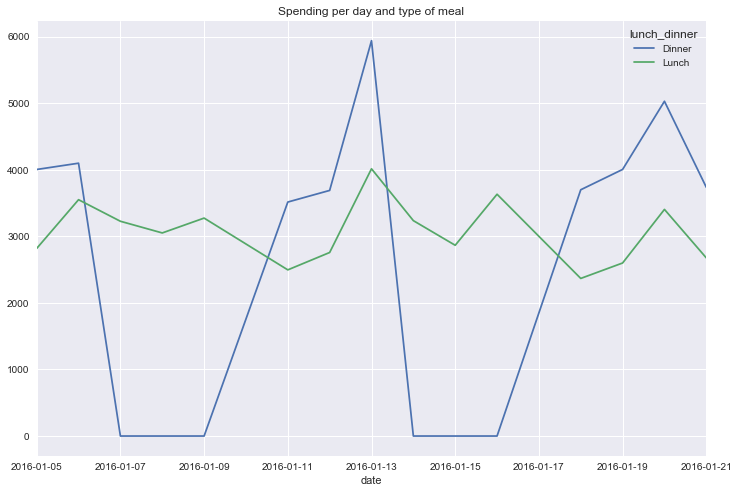

In [21]:
pd.pivot_table(data=train, 
               index=['date'], columns=['lunch_dinner'], 
               values='prod_vProd',
               aggfunc='sum').fillna(0).plot()
plt.title('Spending per day and type of meal')
plt.savefig('./plots/spending_day_type.png')

It is interesting that dinner spendings occurs only in a few days - 2 times in the first week and 3 times in the next 2 following weeks. Also, Lunch spending seems stationary, at least visually.

#### Products

The top-10 are:

In [22]:
prod_counter.most_common(10)

[('BUFFET', 1504),
 ('REFRIGERANTE', 704),
 ('AGUA', 391),
 ('SUCO', 167),
 ('CERVEJA', 88),
 ('CHA', 80),
 ('CERVEJA LATA', 61),
 ('LIMONADA', 50),
 ('SUSHI ESPECIAL', 44),
 ('DOCINHOS', 41)]

In [23]:
train.groupby(by='prod_xProd')['prod_vProd'].describe()

,count,mean,std,min,25%,50%,75%,max
prod_xProd,,,,,,,,
AGUA,391.0,6.314322,4.603714e+00,3.50,3.500,3.50,10.500,31.50
BACARDI,1.0,7.000000,NaN,7.00,7.000,7.00,7.000,7.00
BUFFET,1504.0,46.026975,2.951877e+01,7.68,26.305,36.49,58.205,335.86
BULE CHA,8.0,8.200000,1.899005e-15,8.20,8.200,8.20,8.200,8.20
CAFE EXPRESSO,18.0,4.277778,1.919116e+00,3.50,3.500,3.50,3.500,10.50
CAIPIRINHA,7.0,15.428571,5.855400e+00,12.00,12.000,12.00,18.000,24.00
CAIPIROSKA,9.0,17.000000,4.974937e+00,15.00,15.000,15.00,15.000,30.00
CERVEJA,88.0,7.715341,6.111034e+00,4.50,4.500,4.50,9.000,36.00
CERVEJA LATA,61.0,13.157377,1.254098e+01,6.00,6.500,9.80,13.000,78.40


A few interesting insights can be extracted from the above table:
* the average spending with BUFFET is 83% of average receipt spending. So people might get a BUFFET with something else;
* there are very high values for SUSHI, CERVEJA LATA, CERVEJA, REFRIGERANTE and BUFFET, indicating that one receipt can contain more than one person's spending

It might be useful to group the products. BUFFET, REFRIGERANTE and AGUA are, by far, the most common ones. SUCO is also common, although it is half as frequent as AGUA.

The insights we can infer is that it since it is a buffet restaurant, it is reasonable that those are the most common items, i.e., the food + beverage.

So, we might create 3 different groups:
* BUFFET;
* RAS (REFIRGERANTE, AGUA or SUCO);
* OTHER (all of the items that aren't one of the above).

In [24]:
def product_grouping(data):
    data['prod_group'] = data['prod_xProd'].apply(lambda x: 'BUFFET' if x == 'BUFFET' else \
                                                  ('RAS' if (x == 'REFRIGERANTE') | (x == 'AGUA') | (x == 'SUCO') \
                                                   else 'OTHER'))
    
    return data

In [25]:
train = product_grouping(train)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


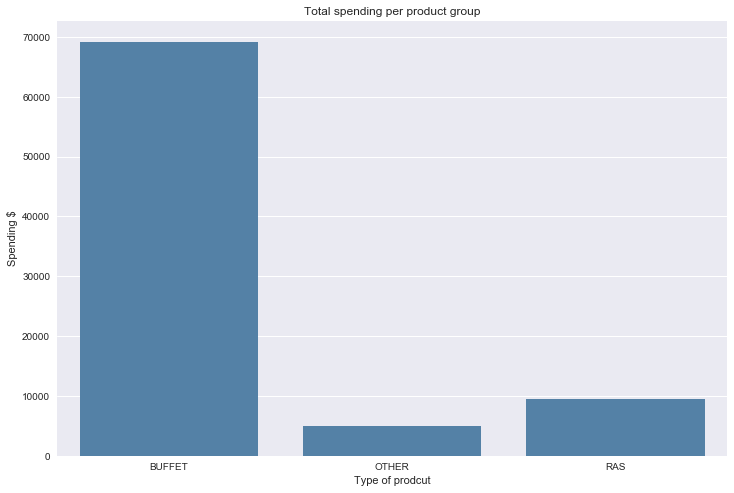

In [26]:
sns.barplot(x='prod_group', y='prod_vProd', 
            data=train.groupby(by=['prod_group']).sum().reset_index(), 
            color='steelblue')

plt.title('Total spending per product group')
plt.ylabel('Spending $')
plt.xlabel('Type of prodcut')
plt.savefig('./plots/total_spending_product_group.png')

---

## 3. Forecasting

From the analysis before it is clear that type of meal as well as we can see a some seasonality on day of the week.

Unfortunately, we have a very small dataset when grouping by week and day, for instance, meaning that we would have only 3 samples per day of the week and that does not bring much statistical power when building a model. Also, out-of-sample validation is challenging in this case, because we would sacrifice samples to train our model. Yet, we arbitrarily chose a 2-day period as a holdout (validation) set.

Therefore, we rely on simple models as benchmarks such as historical mean and historical median. On top of that, let's try Facebook's prophet package to automatically forecast sales. Our evaluation metric will be mean squared error. 

In the end, we should use model averaging as our final forecast.

In [27]:
def sales_forecasting(fcst_period, train_data, model, plot=False):
    """ fcst_period : number of periods to be forecasted
        train_data  : data used to fit the model. To benefit from prophet's structure, should be a data frame with a ds column with dates 
    and a y column with the target variable
        model       : string acting as a selector of models
                        hist_mean   -> historical mean
                        hist_median -> historical median
                        prophet     -> Facebook's prophet
    """
    
    forecast_frame = pd.DataFrame()
    start_date = train_data['ds'].iloc[-1] + datetime.timedelta(days=1) # take last day on training data and add 1 day (start date for forecasting)
    forecast_frame['ds'] = pd.date_range(start=start_date, periods=fcst_period)
    
    if model == 'hist_mean': # historical mean forecast
        forecast_frame['yhat'] = train_data['y'].mean()
        return forecast_frame
    
    elif model == 'hist_median': # historical median forecast
        forecast_frame['yhat'] = train_data['y'].median()
        return forecast_frame
    
    elif model == 'prophet': # prophet model
        prophet = Prophet()
        prophet.fit(train_data)
        future = prophet.make_future_dataframe(periods=fcst_period)
        prophet_fcst = prophet.predict(future)
        
        if plot:
            print()
            print('Prophet plots')
            prophet.plot(prophet_fcst)
            prophet.plot_components(prophet_fcst)
        
        return prophet_fcst[['ds', 'yhat']]

In [28]:
def prepare_data_fitting(data):
    df = (data.resample('D').sum().reset_index())[['ide_dhEmi_$date', 'prod_vProd']].fillna(0)
    df.columns = ['ds', 'y']
    return df

Let's evaluate the models for our holdout period (equivalent of 2-period forecast)

hist_mean MSE: 2,080,551
hist_median MSE: 6,273,270
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.

Prophet plots
prophet MSE: 90,706


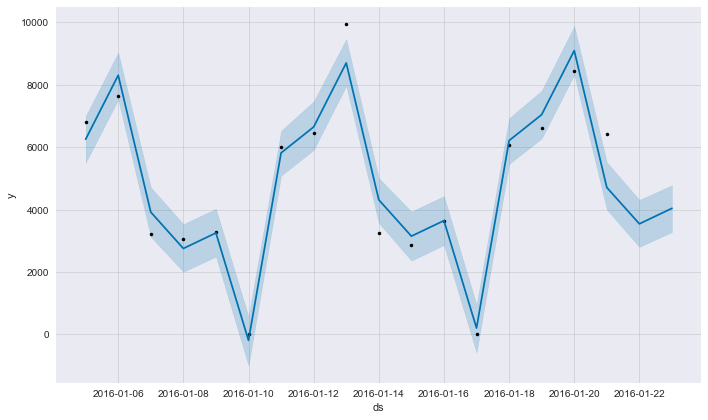

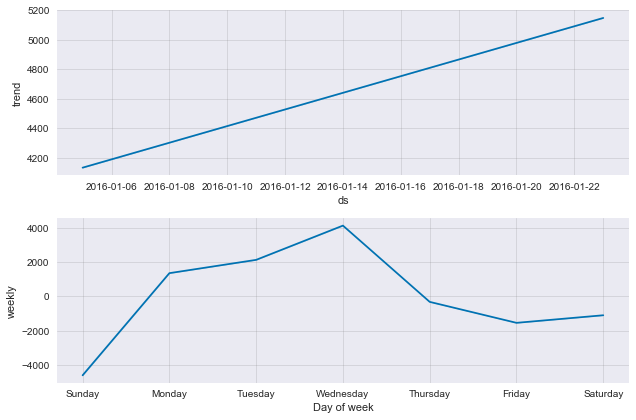

In [29]:
models = ['hist_mean', 'hist_median', 'prophet']
fcst_period = 2
train_prepared = prepare_data_fitting(train)
y_test = test.groupby(['date']).sum()['prod_vProd']

for m in models:
    y_pred = sales_forecasting(fcst_period, train_prepared, m, plot=True)['yhat'].iloc[-fcst_period:] # only forecast period 
                                                                                             #(prophet return the whole fitted and predicted period)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    print('{} MSE: {:,.0f}'.format(m, mse))

Prophet approach could reduce the mean and median loss by 20-60 times.

For our final model, we should calculate an average of the 3 forecasts weighted by 1/MSE of each model - i.e. the smaller the error, the higher weight.

In [30]:
y_pred_hist_mean = sales_forecasting(fcst_period, train_prepared, models[0])['yhat'].iloc[-fcst_period:]
mse_hist_mean = mean_squared_error(y_true=y_test, y_pred=y_pred)

y_pred_hist_mean = sales_forecasting(fcst_period, train_prepared, models[1])['yhat'].iloc[-fcst_period:]
mse_hist_median = mean_squared_error(y_true=y_test, y_pred=y_pred)

y_pred_hist_mean = sales_forecasting(fcst_period, train_prepared, models[2])['yhat'].iloc[-fcst_period:]
mse_prophet = mean_squared_error(y_true=y_test, y_pred=y_pred)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [31]:
weights = [1 / mse_hist_mean, 
           1 / mse_hist_median, 
           1 / mse_prophet]
weights_sum = np.sum(weights)

In [32]:
fcst_period = 9 # 2 days for validation set + 6 days of "next week" (Mon-Sat)
y_preds_df = pd.DataFrame() # populate dataframe with precitions

for i, m in enumerate(models):
    y_pred = sales_forecasting(fcst_period, train_prepared, m)
    fcst = y_pred['yhat'].iloc[-6:].sum() # only Mon-Sat
    print('{} next week forecast: $ {:,.2f}'.format(m, fcst))
    
    if i == 1:
        y_preds_df.set_index(y_pred.ds.iloc[-6:], inplace=True)
    y_preds_df[m] = y_pred['yhat'].iloc[-6:].values

hist_mean next week forecast: $ 29,533.82
hist_median next week forecast: $ 36,064.26
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
prophet next week forecast: $ 37,010.80


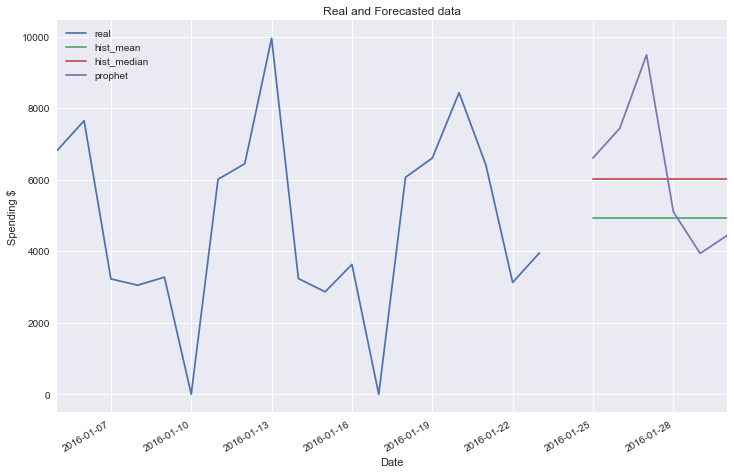

In [33]:
real_and_fcst = pd.concat([data.resample('D').sum()['prod_vProd'].fillna(0), y_preds_df], axis=1)
real_and_fcst.columns = ['real'] + models
real_and_fcst.plot()
plt.title('Real and Forecasted data')
plt.xlabel('Date')
plt.ylabel('Spending $')
plt.savefig('./plots/real_fcst.png')

In [34]:
final_fcst = np.dot(y_preds_df.sum(axis=0), weights) / weights_sum
print('Next week spending forecast is $ {:,.2f}'.format(final_fcst))

Next week spending forecast is $ 34,202.96
